In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomTranslation
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import load_model

from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

<h1>Patrick Barry CA</h1>
<p>My classifier will identify if a given image is a maple tree leaf or a horse-chestnut tree leaf.</p>
<p>I chose these as they have similar shapes generally, similar colours (other than red maple) but a human could easily differentiate between them.</p>
<p>Let's see how a CNN will do.</p>

In [3]:
base_dir = "./"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

(-0.5, 255.5, 255.5, -0.5)

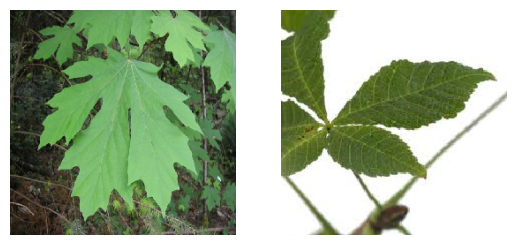

In [4]:
train_maple_dir = os.path.join(train_dir, "maple")
filenames_m = [os.path.join(train_maple_dir, filename) for filename in os.listdir(train_maple_dir)]
train_hc_dir = os.path.join(train_dir, "horse_chestnut")
filenames_hc = [os.path.join(train_hc_dir, filename) for filename in os.listdir(train_hc_dir)]

idx = 18 # Change this if you want to look at a different image
m_example = load_img(filenames_m[idx], target_size=(256,256))
hc_example = load_img(filenames_hc[idx], target_size=(256,256))
ax = plt.subplot(1, 2, 1)
plt.imshow(m_example)
plt.axis("off")
ax = plt.subplot(1, 2, 2)
plt.imshow(hc_example)
plt.axis("off")


Easy enough to distinguish between the 2. But will it be easy for a CNN?

<h2>Data Preprocessing</h2>
<ul>
    <li>Keras has the function: <code>image_dataset_from_directory</code>. There are many arguments to be considered but we only need to think about:
        <ul>
            <li><code>directory</code>: where the data is located.</li>
            <li><code>label_mode</code>: We will use "binary",  
                because we only have two classes (labels), which will be encoded as 0 or 1
            </li>
            <li><code>image_size</code>: Our dataset contains images of different sizes. The neural network
                can't work like this, so the images must all be resized to the same size. The default is 
                $256 \times 256$. We shall investigate if this is the optimal size for our images.
            </li>

In [5]:
# train_dataset = image_dataset_from_directory(directory=train_dir, label_mode="binary")
# val_dataset = image_dataset_from_directory(directory=val_dir, label_mode="binary")
# test_dataset = image_dataset_from_directory(directory=test_dir, label_mode="binary")

In [6]:
train_dataset = image_dataset_from_directory(directory=train_dir, label_mode="binary", image_size=(224, 224))
val_dataset = image_dataset_from_directory(directory=val_dir, label_mode="binary", image_size=(224, 224))
test_dataset = image_dataset_from_directory(directory=test_dir, label_mode="binary", image_size=(224, 224))

Found 100 files belonging to 2 classes.
Metal device set to: Apple M1
Found 48 files belonging to 2 classes.
Found 50 files belonging to 2 classes.


2023-02-03 11:40:06.061198: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-03 11:40:06.061570: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<h1>Pretrained Convolutional Neural Networks</h1>
<ul>
    <li>There are a number of pre-trained CNNs available in keras.</li>
    <li>We will try:
        <ul>
            <li>VGG16</li>
            <li>ResNet50</li>
            <li>Inception V3</li>
        </ul>
    </li>
</ul>

<h1>VGG16</h1>
VGG16 is a CNN developed in Oxford in 2014 by Karen Simonyan and Andrew Zisserman. It comprises of 13 convolutional layers, 3 dense layers, and 5 max pooling layers. 16 layers with learnable paramaters, hence VGG16.

In [7]:
vgg16 = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))

In [8]:
predictions = vgg16.predict(val_dataset)
decode_predictions(predictions, top=3)

2023-02-03 11:40:08.837805: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-03 11:40:08.838901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 792ms/step


[[('n04371774', 'swing', 0.11219489),
  ('n04589890', 'window_screen', 0.067035556),
  ('n02480495', 'orangutan', 0.061389226)],
 [('n03930313', 'picket_fence', 0.48443297),
  ('n03991062', 'pot', 0.060282294),
  ('n02206856', 'bee', 0.05735246)],
 [('n04136333', 'sarong', 0.14444973),
  ('n03991062', 'pot', 0.079835415),
  ('n12768682', 'buckeye', 0.05553498)],
 [('n03782006', 'monitor', 0.35681778),
  ('n04152593', 'screen', 0.13590409),
  ('n04404412', 'television', 0.08963308)],
 [('n03325584', 'feather_boa', 0.44868383),
  ('n03930313', 'picket_fence', 0.058437187),
  ('n09256479', 'coral_reef', 0.04845459)],
 [('n01824575', 'coucal', 0.09783407),
  ('n01682714', 'American_chameleon', 0.0425959),
  ('n02489166', 'proboscis_monkey', 0.040011846)],
 [('n03991062', 'pot', 0.17814033),
  ('n07714571', 'head_cabbage', 0.15917353),
  ('n07745940', 'strawberry', 0.10701918)],
 [('n03598930', 'jigsaw_puzzle', 0.46412253),
  ('n12267677', 'acorn', 0.41186124),
  ('n03908714', 'pencil_sharp

Here is the point where I could experiment with image size, switching all 224s to 256s. However, it already takes long enough to run the notebook without the experiments, so my conclusion is that 224 is optimal.

In [9]:
vgg16_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [10]:
inputs = Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = vgg16_base(x)
x = Flatten()(x)
outputs = Dense(1, activation="sigmoid")(x)
vgg16_model = Model(inputs=inputs, outputs=outputs)

In [11]:
vgg16_base.trainable = False

In [12]:
vgg16_model.compile(optimizer=RMSprop(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])

In [13]:
vgg16_model_history = vgg16_model.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

2023-02-03 11:40:10.981550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 11:40:13.791069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot: >

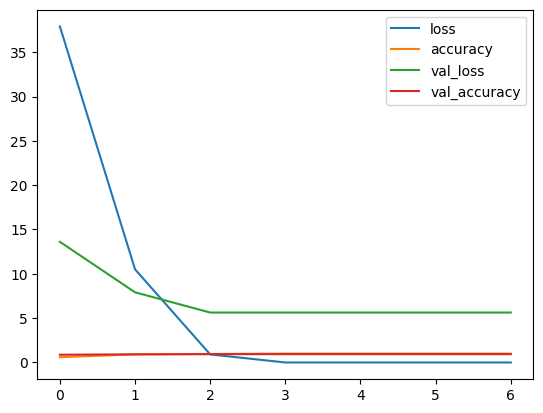

In [14]:
pd.DataFrame(vgg16_model_history.history).plot()

In [15]:
val_loss, val_acc = vgg16_model.evaluate(val_dataset)
val_acc

2/2 [==============================] - 1s 285ms/step - loss: 5.6329 - accuracy: 0.9375


0.9375

The weights are currently fixed, so we shall change that and see if it improves our score.
No batch normalization layers, so we can make all layers trainable.

In [16]:
vgg16_base.trainable = True

In [17]:
vgg16_model.compile(optimizer=RMSprop(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])

In [18]:
vgg16_model_history = vgg16_model.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

2023-02-03 11:40:35.228483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 11:40:43.813297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot: >

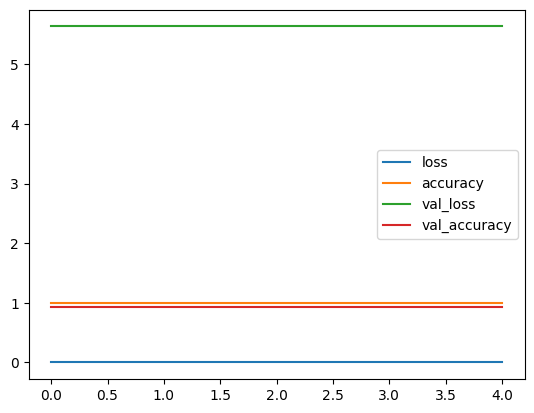

In [19]:
pd.DataFrame(vgg16_model_history.history).plot()

In [20]:
val_loss, val_acc = vgg16_model.evaluate(val_dataset)
val_acc

2/2 [==============================] - 1s 288ms/step - loss: 5.6329 - accuracy: 0.9375


0.9375

This model is much worse when the base layers are made trainable so we shall reset back to not trainable.

In [21]:
vgg16_base.trainable = False

In [22]:
vgg16_model.compile(optimizer=RMSprop(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])

In [23]:
vgg16_model.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

2023-02-03 11:41:20.823912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 11:41:23.361412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<p>VGG16 is definitely a network we can consider, it seems to get high accuracy on our dataset, but it isn't always consistent.</p>
<p>On one run through, it may get a considerably high accuracy, while on the next, it will be much lower.
Because of this instability, let's investigate some other CNNs available to us.</p>

<h1>Inception V3</h1>

In [24]:
inception_base = InceptionV3(weights="imagenet", include_top=False, input_shape=(224,224, 3))

In [25]:
inputs = Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = inception_base(x)
x = Flatten()(x)
outputs = Dense(1, activation="sigmoid")(x)
inception_model = Model(inputs=inputs, outputs=outputs)

In [26]:
inception_base.trainable = False

In [27]:
inception_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5120

In [28]:
inception_model.compile(optimizer=RMSprop(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])

In [29]:
inception_model_history = inception_model.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

2023-02-03 11:41:40.732621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 11:41:43.972639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot: >

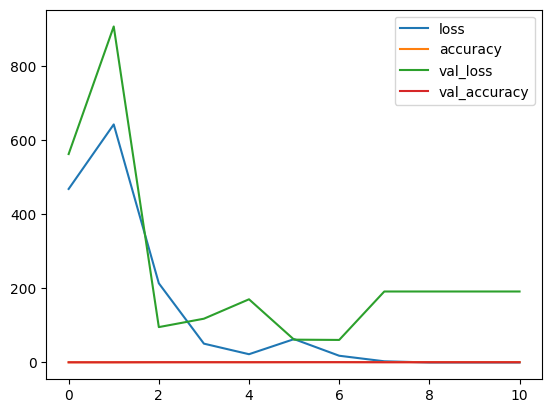

In [30]:
pd.DataFrame(inception_model_history.history).plot()

In [31]:
val_loss, val_acc = inception_model.evaluate(val_dataset)
val_acc

2/2 [==============================] - 0s 97ms/step - loss: 60.8848 - accuracy: 0.8333


0.8333333730697632

<p>We will try making the base trainable, but here we must not allow the batch normalization layers to be trainable.</p>
<p>From the above graph, it looks like the learning rate is too high. Let's also reduce that a little.</p>

In [32]:
for layer in inception_base.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

In [33]:
inception_model.compile(optimizer=RMSprop(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

In [34]:
inception_model_history = inception_model.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

2023-02-03 11:42:03.163575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 11:42:06.762063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot: >

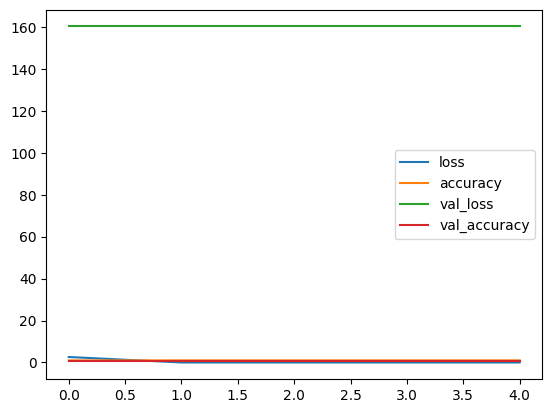

In [35]:
pd.DataFrame(inception_model_history.history).plot()

In [36]:
val_loss, val_acc = inception_model.evaluate(val_dataset)
val_acc

2/2 [==============================] - 0s 106ms/step - loss: 160.2366 - accuracy: 0.6042


0.6041666865348816

<p>Reducing the learning rate has certainly improved the training.</p>
<p>However, the Inception network produces lower accuracy on average than VGG16, so we won't use this network</p>

<h1>ResNet50</h1>

In [37]:
rn50_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [38]:
inputs = Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = rn50_base(x)
x = Flatten()(x)
outputs = Dense(1, activation="sigmoid")(x)
rn50_model = Model(inputs=inputs, outputs=outputs)

In [39]:
rn50_base.trainable = False

In [40]:
rn50_model.compile(optimizer=RMSprop(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])

In [41]:
rn50_model_history = rn50_model.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

2023-02-03 11:42:19.286745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 11:42:23.389646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot: >

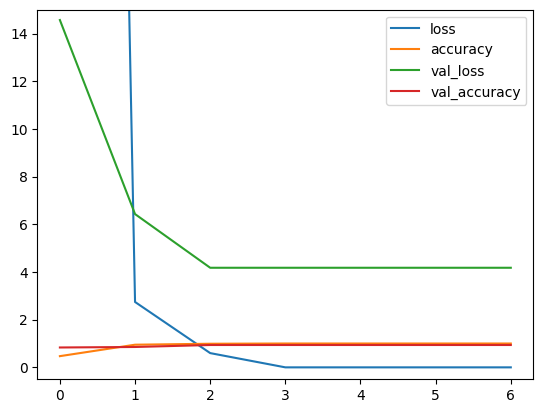

In [42]:
pd.DataFrame(rn50_model_history.history).plot(ylim=(-0.5, 15))

In [43]:
val_loss, val_acc = rn50_model.evaluate(val_dataset)
val_acc

2/2 [==============================] - 1s 173ms/step - loss: 4.1766 - accuracy: 0.9375


0.9375

<p>It is strange that the validation loss is constantly so high but the validation accuracy is also one of the highest we've seen so far.</p>
<p>Let's see if making it trainable has any effect.</p>

In [44]:
for layer in rn50_base.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

In [45]:
rn50_model.compile(optimizer=RMSprop(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])

In [46]:
rn50_model_history = rn50_model.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

2023-02-03 11:42:41.242004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 11:42:45.545719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot: >

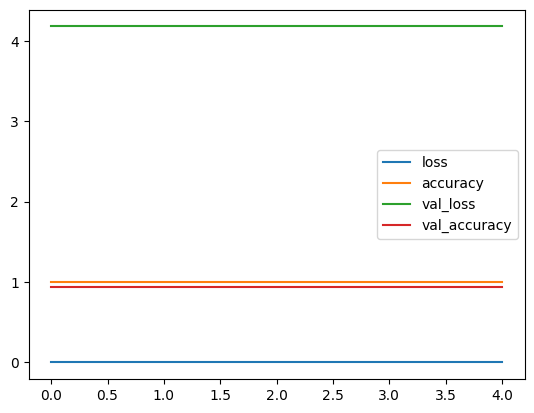

In [47]:
pd.DataFrame(rn50_model_history.history).plot()

In [48]:
val_loss, val_acc = rn50_model.evaluate(val_dataset)
val_acc

2/2 [==============================] - 1s 174ms/step - loss: 4.1766 - accuracy: 0.9375


0.9375

<p>The accuracy is very high, but the validation loss is also still very high which indicates the network is overfitting.</p>
<p>Despite this potential overfitting problem, this network is the most consistent at producing high accuracy, so we will use this network from now on. Let's try something to fix the overfitting.</p>

<h1>Data Augmentation</h1>
<p>An obvious way to reduce overfitting is to add more examples.</p>

In [49]:
inputs = Input(shape=(224, 224, 3))
x = RandomFlip(mode="horizontal")(inputs)
x = RandomRotation(factor=0.1)(x)
x = RandomZoom(height_factor=(-0.2, 0.2))(x)
x = RandomTranslation(height_factor=0.2, width_factor=0.2)(x)
x = preprocess_input(x)
x = rn50_base(x)
x = Flatten()(x)
outputs = Dense(1, activation="sigmoid")(x)
augmented_rn50_model = Model(inputs=inputs, outputs=outputs)

In [50]:
augmented_rn50_model.compile(optimizer=RMSprop(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])

In [51]:
augmented_rn50_model_history = augmented_rn50_model.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

2023-02-03 11:43:01.996597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 11:43:09.021691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot: >

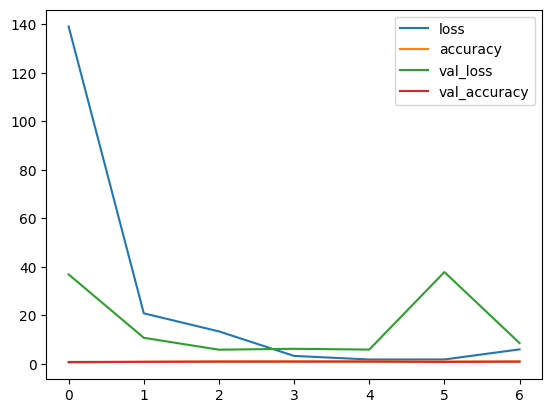

In [52]:
# Let's see of the val loss has changed.
pd.DataFrame(augmented_rn50_model_history.history).plot()

<p>Well , the validation loss has certainly changed, it's no longer constantly around 10, but jumps around quite a bit, ending up below 10.</p>

In [53]:
val_loss, val_acc = augmented_rn50_model.evaluate(val_dataset)
val_acc

2/2 [==============================] - 1s 175ms/step - loss: 5.8014 - accuracy: 0.9167


0.9166666865348816

<p>Data augmentation hasn't had a negative effect on the accuracy of the network, so we shall continue using it.</p>
<p>However, both loss values are now fluctuating up and down, so let's try remedy that.</p>

<h1>Tweaking Settings</h1>

Let's try decreasing the learning rate.

In [54]:
augmented_rn50_model.compile(optimizer=RMSprop(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

In [55]:
augmented_rn50_model_history = augmented_rn50_model.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

2023-02-03 11:43:41.419105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 11:43:48.181346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot: >

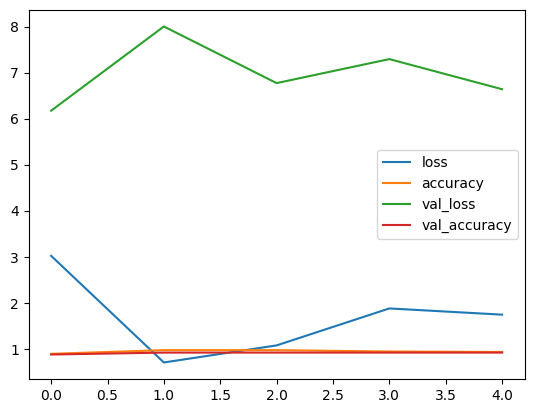

In [56]:
# Let's see of the val loss has changed.
pd.DataFrame(augmented_rn50_model_history.history).plot()

In [57]:
val_loss, val_acc = augmented_rn50_model.evaluate(val_dataset)
val_acc

2/2 [==============================] - 1s 176ms/step - loss: 6.1720 - accuracy: 0.8750


0.875

Loss is still fluctuating quite a bit, but this is likely due to the nature of feeding in mini-batches. One could be rather easy to predict, with the next being much different, causing the loss to increase.

Let's try another hidden dense layer to our network.

In [58]:
inputs = Input(shape=(224, 224, 3))
x = RandomFlip(mode="horizontal")(inputs)
x = RandomRotation(factor=0.1)(x)
x = RandomZoom(height_factor=(-0.2, 0.2))(x)
x = RandomTranslation(height_factor=0.2, width_factor=0.2)(x)
x = preprocess_input(x)
x = rn50_base(x)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)
dense_augmented_rn50_model = Model(inputs=inputs, outputs=outputs)

In [59]:
dense_augmented_rn50_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [60]:
dense_augmented_rn50_model_history = dense_augmented_rn50_model.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

2023-02-03 11:44:22.800343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 11:44:31.888562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot: >

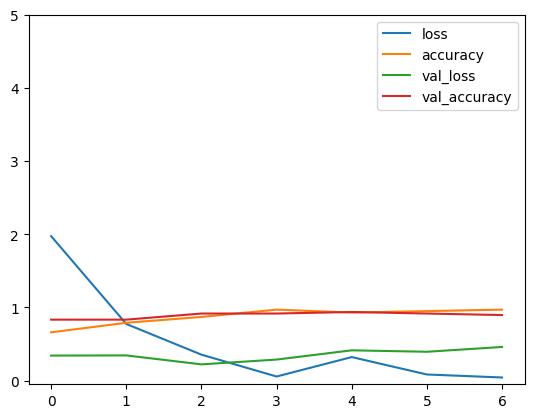

In [61]:
pd.DataFrame(dense_augmented_rn50_model_history.history).plot(ylim=(-0.05, 5))

In [62]:
val_loss, val_acc = dense_augmented_rn50_model.evaluate(val_dataset)
val_acc

2/2 [==============================] - 1s 198ms/step - loss: 0.2220 - accuracy: 0.9167


0.9166666865348816

<p>This seems to have significantly decreased the loss values and increased the accuracy, very promising.</p>
<p>Let's try all our models on the test set.</p>

<h1>Test Time huthuthuthut</h1>

In [63]:
# The inconsistent VGG16 model.
test_loss, test_acc = vgg16_model.evaluate(test_dataset)
test_acc

2/2 [==============================] - 2s 1s/step - loss: 4.0991 - accuracy: 0.9000


0.8999999761581421

In [64]:
# The Inception model, which returned the lowest accuracy of all.
test_loss, test_acc = inception_model.evaluate(test_dataset)
test_acc

2/2 [==============================] - 3s 2s/step - loss: 161.6383 - accuracy: 0.7800


0.7799999713897705

In [65]:
# The ResNet50 transfer model before we tweaked anything.
test_loss, test_acc = rn50_model.evaluate(test_dataset)
test_acc

2/2 [==============================] - 3s 2s/step - loss: 6.3793 - accuracy: 0.9000


0.8999999761581421

In [66]:
# ResNet50 transfer model after data augmentation.
test_loss, test_acc = augmented_rn50_model.evaluate(test_dataset)
test_acc

2/2 [==============================] - 3s 2s/step - loss: 18.0220 - accuracy: 0.7800


0.7799999713897705

In [67]:
# ResNet50 transfer model after data augmentation and some minor tweaks.
test_loss, test_acc = dense_augmented_rn50_model.evaluate(test_dataset)
test_acc

2/2 [==============================] - 2s 2s/step - loss: 0.7562 - accuracy: 0.8000


0.7999999523162842

<h1>Best Model</h1>
We could choose almost any of these except the Inception model, but the one that is most consistent is regular ResNet50 transfer model, before we tweaked anything and before data augmentation.

In [68]:
rn50_model.save("best_network.h5")